In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [2]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [5]:
## change status to an object
df['status'] = df['status'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  object
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(1), object(6)
memory usage: 873.6+ KB


In [6]:
## parse date/ time
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [7]:
## clean up text
#removes "" from strings in a column
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')
#removes the page number
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [8]:
## convert bytes to mb
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [11]:
df.describe()

,size,size_mb
count,1.397800e+04,13978.000000
mean,4.500019e+05,0.429155
std,1.614915e+05,0.154010
min,0.000000e+00,0.000000
25%,5.006370e+05,0.477445
50%,5.101380e+05,0.486506
75%,5.112910e+05,0.487605
max,2.056327e+06,1.961066


In [12]:
# value counts of ip address

df.ip.value_counts(dropna=False)

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
54.172.14.223         1
45.23.250.16          1
3.92.201.136          1
3.88.129.158          1
95.31.18.119          1
54.145.52.184         1
52.91.30.150          1
34.229.70.250         1
35.174.209.2          1
34.207.64.242         1
97.105.15.120         1
95.31.16.121          1
52.90.165.200         1
Name: ip, dtype: int64

In [13]:
# group data frame by ip address
df.groupby('ip').count()

,request_method,status,size,destination,request_agent,size_mb
ip,,,,,,
173.173.113.51,1059,1059,1059,0,1059,1059
24.26.242.9,21,21,21,0,21,21
3.88.129.158,1,1,1,0,1,1
3.92.201.136,1,1,1,0,1,1
34.207.64.242,1,1,1,0,1,1
34.229.70.250,1,1,1,0,1,1
35.174.209.2,1,1,1,0,1,1
35.175.171.137,2,2,2,0,2,2
45.23.250.16,1,1,1,0,1,1


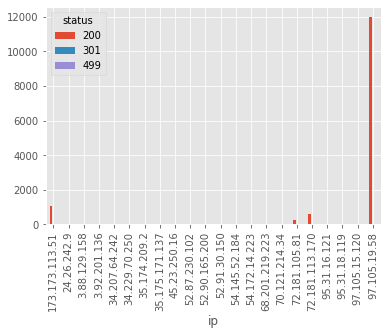

In [38]:
plt.style.use('ggplot')

df.groupby(['ip', 'status'])\
      .ip.count().unstack().plot.bar(legend=True)
plt.show()

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   status          13978 non-null  object 
 3   size            13978 non-null  int64  
 4   destination     25 non-null     object 
 5   request_agent   13978 non-null  object 
 6   size_mb         13978 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.2+ MB


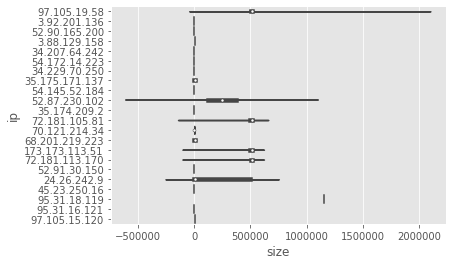

In [43]:
sns.violinplot(y='ip', x='size', data=df)

Findings:
-  Six IP Addresses make greater than 2 observations 

- 97.105.19.58 has the most frequency with the 11,999 requests

In [14]:
df.request_method.value_counts(dropna=False)

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1 HTTP/1.1                                1
GET /api/v1/I_DIDNT_DO_IT!!!

In [15]:
df.groupby('request_method').count()

,ip,status,size,destination,request_agent,size_mb
request_method,,,,,,
GET / HTTP/1.1,107,107,107,3,107,107
GET /api/V1/HiZach! HTTP/1.1,1,1,1,0,1,1
GET /api/v1 HTTP/1.1,1,1,1,0,1,1
GET /api/v1/ HTTP/1.1,4,4,4,0,4,4
GET /api/v1//api/v1/items HTTP/1.1,11,11,11,1,11,11
GET /api/v1//api/v1/items/next_page HTTP/1.1,1,1,1,0,1,1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,1,1,1,0,1,1
GET /api/v1/helloclass! HTTP/1.1,1,1,1,0,1,1
GET /api/v1/items HTTP/1.1,1065,1065,1065,0,1065,1065
